In [1]:
#default_exp zero_shot_learning

In [2]:
#export
from operator import itemgetter

import numpy as np
import tqdm
import bs4
import feedparser
import seaborn as sns
import pandas as pd


from ktrain import text 
import torch


In [3]:
%cd ..

/home/kuba/Projects/pytorch_hackathon


In [4]:
pd.set_option("display.max_colwidth", 250)

# RSS Feeds


In [5]:
#export
medium_publications = [
    'the-artificial-impostor',
    'pytorch',
    'dair.ai',
    'towards-artificial-intelligence',
    'swlh',
    '@ODSC',
    'doctrine',
    'paperswithcode'
]


medium_url_template = 'https://medium.com/feed/{}'
medium_url = medium_url_template.format(medium_publications[0])
medium_urls = [medium_url_template.format(publication) for publication in medium_publications]

In [6]:
#export
subreddits = [
    'MachineLearning',
    'deeplearning',
    'datascience',
    'cognitivelinguistics',
    'TopOfArxivSanity',
    'kaggle'
]

reddit_url_template = 'https://www.reddit.com/r/{}/.rss'
reddit_url = reddit_url_template.format(subreddits[0])
reddit_urls = [reddit_url_template.format(subreddit) for subreddit in subreddits]

In [7]:
#export


def get_article_text(article):
    article_html_content = article['content'][0]['value']
    article_text = bs4.BeautifulSoup(article_html_content).text
    return article_text


def get_feed_article_texts(feed):
    return [get_article_text(article) for article in feed['entries'] if 'content' in article.keys()]


def get_feed_article_df(feed):
    feed_df = pd.DataFrame.from_records(feed['entries'])
    feed_df['text'] = feed_df['summary'].apply(lambda s: bs4.BeautifulSoup(s).text)
    return feed_df


def add_field(df, field_name, values):
    df[field_name] = values
    return df

In [8]:
#export
paperswithcode_url = 'https://us-east1-ml-feeds.cloudfunctions.net/pwc/latest' 
hackernews_url = 'https://news.ycombinator.com/rss' 
rss_feed_urls = [paperswithcode_url, hackernews_url] + medium_urls + reddit_urls

In [9]:
feed_urls = pd.read_table('data/feeds.txt', header=None).iloc[:,0].values

In [10]:
for url in rss_feed_urls:
    print(url)

https://us-east1-ml-feeds.cloudfunctions.net/pwc/latest
https://news.ycombinator.com/rss
https://medium.com/feed/the-artificial-impostor
https://medium.com/feed/pytorch
https://medium.com/feed/dair.ai
https://medium.com/feed/towards-artificial-intelligence
https://medium.com/feed/swlh
https://medium.com/feed/@ODSC
https://medium.com/feed/doctrine
https://medium.com/feed/paperswithcode
https://www.reddit.com/r/MachineLearning/.rss
https://www.reddit.com/r/deeplearning/.rss
https://www.reddit.com/r/datascience/.rss
https://www.reddit.com/r/cognitivelinguistics/.rss
https://www.reddit.com/r/TopOfArxivSanity/.rss
https://www.reddit.com/r/kaggle/.rss


### Loading RSS feed articles to a dataframe

In [11]:
#export
def get_feed_df(feed_urls):
    feeds = [
        (feed_url, feedparser.parse(feed_url))
        for feed_url in tqdm.tqdm(feed_urls)
    ]
    return pd.concat(
        [
            add_field(get_feed_article_df(feed), 'feed', feed_url)
            for (feed_url, feed) in feeds
            if len(feed['entries']) > 0
        ]
    )

In [12]:
feed_df = get_feed_df(rss_feed_urls)

100%|██████████| 16/16 [00:10<00:00,  1.59it/s]


In [13]:
feed_df.shape

(295, 22)

In [14]:
feed_df.head()

,title,title_detail,links,link,summary,summary_detail,id,guidislink,tags,text,...,published_parsed,comments,authors,author,author_detail,updated,updated_parsed,content,href,media_thumbnail
0,I2L-MeshNet: Image-to-Lixel Prediction Network for Accurate 3D Human Pose and Mesh Estimation from a Single RGB Image,"{'type': 'text/plain', 'language': None, 'base': 'https://us-east1-ml-feeds.cloudfunctions.net/pwc/latest', 'value': 'I2L-MeshNet: Image-to-Lixel Prediction Network for Accurate 3D Human Pose and Mesh Estimation from a Single RGB Image'}","[{'rel': 'alternate', 'type': 'text/html', 'href': 'https://paperswithcode.com/paper/i2l-meshnet-image-to-lixel-prediction-network'}]",https://paperswithcode.com/paper/i2l-meshnet-image-to-lixel-prediction-network,"Most of the previous image-based 3D human pose and mesh estimation methods estimate parameters of the human mesh model from an input image. <p>Code: <a href=""https://github.com/mks0601/I2L-MeshNet_RELEASE"">https://github.com/mks0601/I2L-MeshNet_R...","{'type': 'text/html', 'language': None, 'base': 'https://us-east1-ml-feeds.cloudfunctions.net/pwc/latest', 'value': 'Most of the previous image-based 3D human pose and mesh estimation methods estimate parameters of the human mesh model from an in...",https://paperswithcode.com/paper/i2l-meshnet-image-to-lixel-prediction-network,False,"[{'term': '3d hand pose estimation', 'scheme': None, 'label': None}, {'term': '3d human pose estimation', 'scheme': None, 'label': None}]",Most of the previous image-based 3D human pose and mesh estimation methods estimate parameters of the human mesh model from an input image. Code: https://github.com/mks0601/I2L-MeshNet_RELEASE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Polysemy Deciphering Network for Robust Human-Object Interaction Detection,"{'type': 'text/plain', 'language': None, 'base': 'https://us-east1-ml-feeds.cloudfunctions.net/pwc/latest', 'value': 'Polysemy Deciphering Network for Robust Human-Object Interaction Detection'}","[{'rel': 'alternate', 'type': 'text/html', 'href': 'https://paperswithcode.com/paper/polysemy-deciphering-network-for-robust-human'}]",https://paperswithcode.com/paper/polysemy-deciphering-network-for-robust-human,"To address this issue, in this paper, we propose a novel Polysemy Deciphering Network (PD-Net) that decodes the visual polysemy of verbs for HOI detection in three distinct ways. <p>Code: <a href=""https://github.com/MuchHair/PD-Net"">https://githu...","{'type': 'text/html', 'language': None, 'base': 'https://us-east1-ml-feeds.cloudfunctions.net/pwc/latest', 'value': 'To address this issue, in this paper, we propose a novel Polysemy Deciphering Network (PD-Net) that decodes the visual polysemy o...",https://paperswithcode.com/paper/polysemy-deciphering-network-for-robust-human,False,"[{'term': 'Human-object interaction detection', 'scheme': None, 'label': None}, {'term': 'Scene understanding', 'scheme': None, 'label': None}]","To address this issue, in this paper, we propose a novel Polysemy Deciphering Network (PD-Net) that decodes the visual polysemy of verbs for HOI detection in three distinct ways. Code: https://github.com/MuchHair/PD-Net",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Cascade Graph Neural Networks for RGB-D Salient Object Detection,"{'type': 'text/plain', 'language': None, 'base': 'https://us-east1-ml-feeds.cloudfunctions.net/pwc/latest', 'value': 'Cascade Graph Neural Networks for RGB-D Salient Object Detection'}","[{'rel': 'alternate', 'type': 'text/html', 'href': 'https://paperswithcode.com/paper/cascade-graph-neural-networks-for-rgb-d'}]",https://paperswithcode.com/paper/cascade-graph-neural-networks-for-rgb-d,"Current works either simply distill prior knowledge from the corresponding depth map for handling the RGB-image or blindly fuse color and geometric information to generate the coarse depth-aware representations, hindering the performance of RGB-D...","{'type': 'text/html', 'language': None, 'base': 'https://us-east1-

### Zero-shot learning

Using self-attention models from [huggingface transformers](https://github.com/huggingface/transformers) it is possible to run unsupervised text classification. This can be also viewed as (soft) clustering with side information on clusters.

This approach for zero-shot learning uses classes that are texts themselves, and leverages text embeddings to do classification.

The following code uses [ktrain](https://github.com/amaiya/ktrain) library's implementation - it uses pretrained model for Natural Language Inference to classify texts. For the details of this approach see [Zero-Shot Learning in Modern NLP](https://joeddav.github.io/blog/2020/05/29/ZSL.html) blog post.

In [15]:
zsl_clf = text.ZeroShotClassifier(device='cuda')

In [16]:
zsl_clf 

In [17]:
example_article = feed_df.iloc[0]
example_article_text = example_article['text']

In [18]:
#export
topic_strings = [
    'deep learning',
    'natural language processing',
    'computer vision',
    'statistics',
    'business intelligence',
    'visualization',
    'industry',
    'implementation',
    'software engineering',
    'reddit question',
    'science',
    'cloud computing',
    'deployment',
    'business'
]

In [19]:
topic_strings = pd.read_table('data/topics.txt', header=None).iloc[:,0].values

In [20]:
#export

def get_zero_shot_classification_results(zsl_clf, text, topic_strings, max_length=128, sort=True):
    text_length = len(text.split())
    results = zsl_clf.predict(text, topic_strings=topic_strings, include_labels=True, batch_size=len(topic_strings), max_length=min(max_length, text_length))
    if sort:
        return sorted(results, key=itemgetter(1), reverse=True)
    else:
        return results


def get_zero_shot_classification_results_df(zsl_clf, texts, topic_strings, progbar_wrapper=tqdm.tqdm):
    results_df = pd.DataFrame(np.zeros((len(texts), len(topic_strings))), columns=sorted(topic_strings))
    for i, text in enumerate(progbar_wrapper(texts)):
        results = get_zero_shot_classification_results(zsl_clf, text, topic_strings)
        results_df.iloc[i] = pd.Series(dict(sorted(results, key=itemgetter(0))))
    return results_df

In [21]:
results = get_zero_shot_classification_results(zsl_clf, example_article_text, topic_strings)
results = sorted(results, key=itemgetter(1), reverse=True)

In [22]:
pd.Series(dict(results))

computer vision                0.663394
software engineering           0.414764
visualization                  0.287666
deep learning                  0.113754
arxiv                          0.097541
business intelligence          0.045340
implementation                 0.019770
industry                       0.016407
deployment                     0.011904
cloud computing                0.008510
business                       0.008450
competitions                   0.008429
reddit question                0.007256
statistics                     0.003227
natural language processing    0.000321
dtype: float64

In [23]:
feed_df['text'].iloc[:100].to_csv('texts.csv')

In [24]:
results_df = get_zero_shot_classification_results_df(
    zsl_clf,
    feed_df['text'],
    topic_strings
)

100%|██████████| 295/295 [01:24<00:00,  3.50it/s]


In [25]:
feed_df[['title', 'text', 'feed', 'link']].reset_index().join(results_df.round(3)).to_csv('feed_topics.csv', index=False)

In [26]:
example_article[['title', 'text']]

title                                                                               I2L-MeshNet: Image-to-Lixel Prediction Network for Accurate 3D Human Pose and Mesh Estimation from a Single RGB Image
text     Most of the previous image-based 3D human pose and mesh estimation methods estimate parameters of the human mesh model from an input image. Code: https://github.com/mks0601/I2L-MeshNet_RELEASE
Name: 0, dtype: object

In [27]:
categories = [c for c, __ in results]
scores = [score for __, score in results]

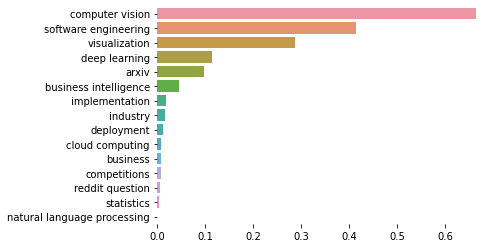

In [28]:
sns.barplot(scores, categories)
sns.despine(left=True, bottom=True)